In [1]:
!pip install dask dask[dataframe] dask-ml


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.5/205.5 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.0 MB/s eta 0:00:00


Mounted at /content/drive
[########################################] | 100% Completed | 114.26 ms


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Acurácia: 0.129500599880024
Precisão: 0.1750631624661312
Recall: 0.129500599880024
F1-Score: 0.10988559147836381


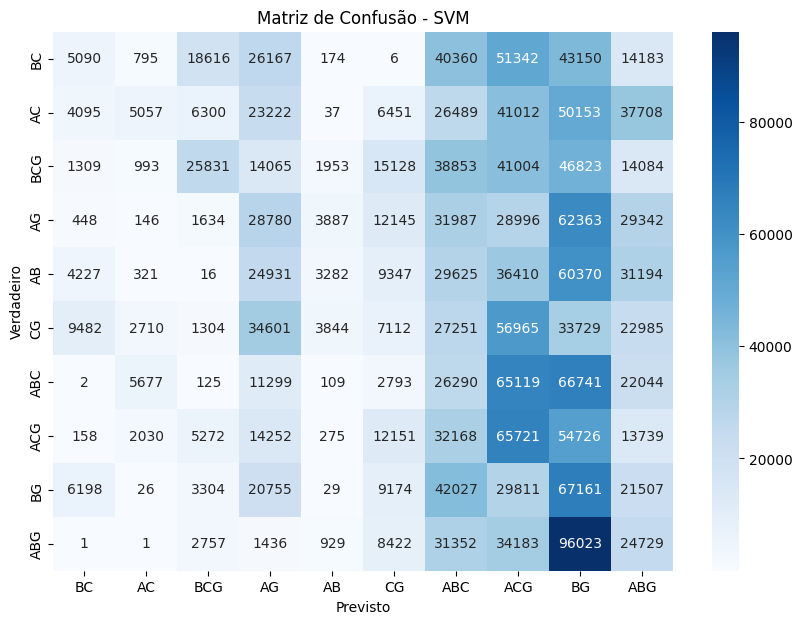

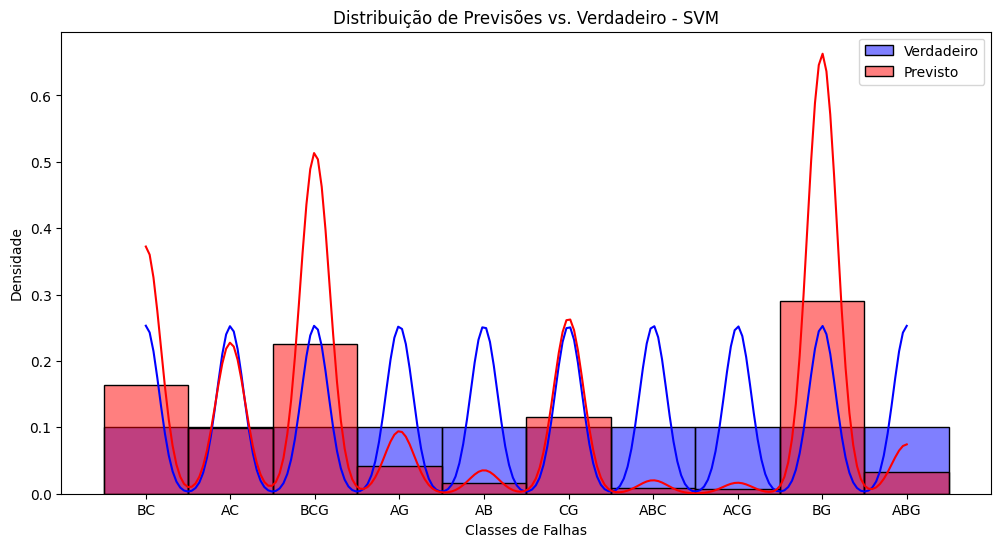

In [4]:
import os
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask_ml.preprocessing import StandardScaler as DaskScaler
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Monta o Google Drive
drive.mount('/content/drive')

# Função para carregar dados usando Dask
def load_data(filepath, cols_to_use):
    return dd.read_csv(filepath, usecols=cols_to_use)

# Função para pré-processar os dados com Dask
def preprocess_data(df):
    return df

# Função para detectar e tratar anomalias
def detect_and_treat_anomalies(df):
    z_scores = ((df - df.mean()) / df.std()).abs()
    df = df[z_scores < 3].dropna()  # Remove valores com z-score > 3
    return df

# Aplicando StandardScaler
def scale_data(df):
    scaler = DaskScaler()
    df = scaler.fit_transform(df)
    return df

# Função para adicionar rótulo com base na pasta
def add_labels(df, label):
    df['label'] = label
    return df

# Função para balancear classes usando SMOTE
def balance_classes(df):
    smote = SMOTE()
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    X_res, y_res = smote.fit_resample(X.compute(), y.compute())
    balanced_df = pd.concat([X_res, y_res], axis=1)
    return dd.from_pandas(balanced_df, npartitions=1)

# Processamento dos arquivos usando Dask
def process_files_in_folder_dask(folder_path, cols_to_use, label):
    files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]
    if not files:
        return dd.from_pandas(pd.DataFrame(), npartitions=1)
    df = dd.concat([load_data(file, cols_to_use) for file in files], axis=0)
    df = preprocess_data(df)
    df = detect_and_treat_anomalies(df)
    df = scale_data(df)
    df = df.map_partitions(lambda df_partition: add_labels(df_partition, label))
    return df

# Processamento paralelo das pastas usando Dask
def process_all_folders_dask(base_path, subfolders):
    folder_paths = [os.path.join(base_path, subfolder) for subfolder in subfolders if os.path.exists(os.path.join(base_path, subfolder))]
    results = []
    for folder_path in folder_paths:
        label = os.path.basename(folder_path)
        df = process_files_in_folder_dask(folder_path, ['v:X0014A', 'v:X0014B', 'v:X0014C', 'v:X0013A', 'v:X0013B', 'v:X0013C',
                                                        'c:X0013A:BUS8A', 'c:X0013B:BUS8B', 'c:X0013C:BUS8C',
                                                        'c:BUS9A:X0014A', 'c:BUS9B:X0014B', 'c:BUS9C:X0014C'], label)
        results.append(df)
    if results:
        final_df = dd.concat(results, axis=0)
        final_df = balance_classes(final_df)
        return final_df
    else:
        return dd.from_pandas(pd.DataFrame(), npartitions=1)

# Chamada principal
base_path = '/content/drive/MyDrive/Amostra'
subfolders = ['AB', 'ABC', 'ABG', 'AC', 'ACG', 'AG', 'BG', 'BCG', 'BC', 'CG']

# Processando os dados
final_df = process_all_folders_dask(base_path, subfolders)

# Convertendo para pandas DataFrame
with ProgressBar():
    final_df = final_df.compute()

# Separando as características e os rótulos
X = final_df.drop('label', axis=1)
y = final_df['label']

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando e treinando o modelo SVM com limitação de iterações e tolerância ajustada
model = SVC(kernel='linear', max_iter=1000, tol=1e-3)
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_test)

# Calculando métricas de desempenho
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Função para plotar a matriz de confusão
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Matriz de Confusão - SVM')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.show()

# Função para plotar o histograma de previsões vs verdadeiro
def plot_predictions_vs_true(y_test, y_pred):
    plt.figure(figsize=(12, 6))
    sns.histplot(y_test, color='blue', label='Verdadeiro', kde=True, stat="density", bins=30)
    sns.histplot(y_pred, color='red', label='Previsto', kde=True, stat="density", bins=30)
    plt.title('Distribuição de Previsões vs. Verdadeiro - SVM')
    plt.xlabel('Classes de Falhas')
    plt.ylabel('Densidade')
    plt.legend()
    plt.show()

# Plot matriz de confusão
labels = y_test.unique()
plot_confusion_matrix(conf_matrix, labels=labels)

# Plothistograma de previsões vs verdadeiro
plot_predictions_vs_true(y_test, y_pred)
